In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp

from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True)

## Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


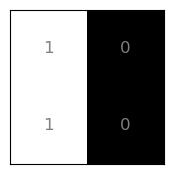

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

### Getting Wavefunction of Dataset

In [4]:
target_psi = np.zeros(2**4)
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = []
for i in bitstrings_target:
    nums_target += [int(i, 2)]
print(nums_target)

[0, 3, 5, 10, 12, 15]


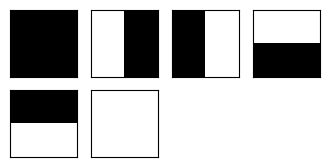

In [5]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [6]:
target_amps = 1/math.sqrt(len(nums_target))
for i in nums_target:
    target_psi[i] = target_amps

In [7]:
target_dm = np.outer(target_psi,target_psi.conj())


In [8]:
################ Checking the pennylane function qml.math.reduce_statevector()


# bitstrings = ['0000000','0011001','0101010','1010011','1100100','1111101']
# nums = []
# for i in bitstrings:
#     nums += [int(i, 2)]
# print(nums)

# psi = np.zeros(2**7)
# amps = 1 / math.sqrt(len(bitstrings))
# for i in nums:
#     psi[i] = amps
# dm = np.outer(psi,psi.conj())

# reduced_dm = qml.math.reduce_statevector(target_psi,indices=[0,1,2,3])
# # reduced_dm = qml.math.reduce_dm(dm,indices=[0,1,2,3])

# pxy = reduced_dm - target_dm
# dagger_pxy = qml.math.conj(qml.math.transpose(pxy)) # Compute Hermitian conjugate
# loss = 0.5 * qml.math.trace(qml.math.sqrt_matrix(dagger_pxy * pxy))
# loss


## Functions

In [9]:
from pennylane.math import reduce_statevector
from pennylane import math as qmlmath

n_qubits = 4
n_ancillas = 3
total_qubits = n_qubits + n_ancillas

class TraceDistanceLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    def tr_distance(self, pxy):
        """
        Compute the trace distance of the difference matrix pxy.
        
        Parameters:
            pxy (numpy.ndarray): Difference of two probability distributions.
        
        Returns:
            float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
        """
        dagger_pxy = qmlmath.conj(qmlmath.transpose(pxy)) # Compute Hermitian conjugate
        return 0.5 * qmlmath.trace(qmlmath.sqrt_matrix(dagger_pxy * pxy))
        # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        pxy = px - py
        return self.tr_distance(pxy)
    
class QCBM:

    def __init__(self,circ,trdistance,py):
        self.circ = circ
        self.trdistance = trdistance
        self.py = py

    def qcbm_loss(self,params):
        full_psi = self.circ(params)
        px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.trdistance(px,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

In [10]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):
    
    params = qnp.array(input_params, requires_grad=True)
    
    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


## Training the Model

In [11]:
key = jax.random.PRNGKey(1)
initial_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * total_qubits), requires_grad=True)

#initial_params = jax.random.uniform(key, shape=(folds, (3 * total_qubits)), minval=0.0, maxval=2*math.pi)

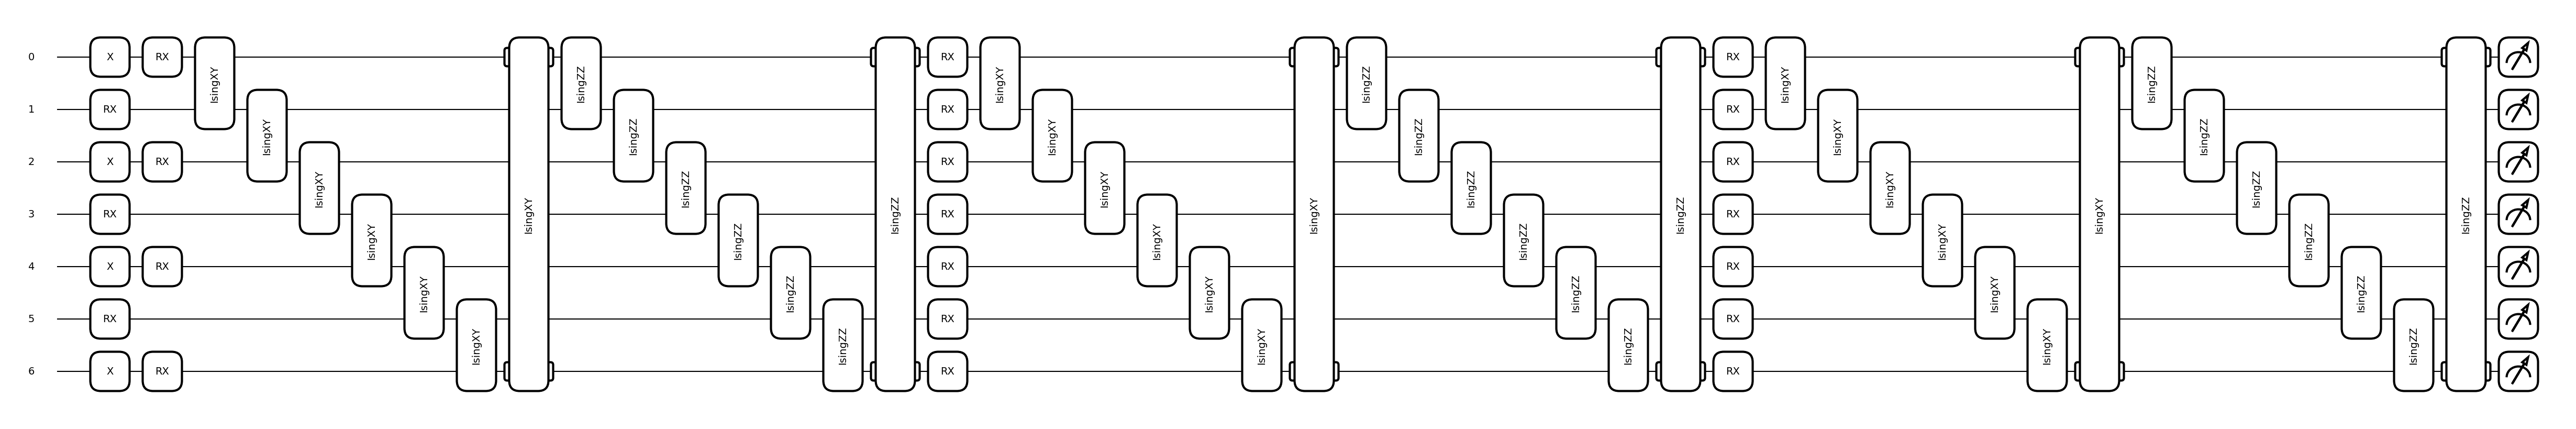

In [12]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [13]:
tr_distance = TraceDistanceLoss()
qcbm = QCBM(circuit,tr_distance,target_dm)

weights = initial_params#.flatten()
# lr = 1
opt = AdamOptimizer(stepsize=0.01)
# opt = GradientDescentOptimizer(stepsize=0.1)
# opt_state = opt.init(weights)

loss = []
parameters = []
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = qcbm.qcbm_loss(weights)
    weights = opt.step(qcbm.qcbm_loss,weights)
    # grad = grad(qcbm.qcbm_loss)()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    loss.append(loss_val)
    parameters.append(weights)


Step: 10 Loss: 0.47338785890645957 Time taken per iter: 0.05094289779663086
Step: 20 Loss: 0.4490496488736573 Time taken per iter: 0.04900407791137695
Step: 30 Loss: 0.42571280926369265 Time taken per iter: 0.048490047454833984
Step: 40 Loss: 0.40398840739176567 Time taken per iter: 0.01974201202392578
Step: 50 Loss: 0.3797456797918427 Time taken per iter: 0.019404172897338867
Step: 60 Loss: 0.3556708685881185 Time taken per iter: 0.020107030868530273
Step: 70 Loss: 0.33023924273120187 Time taken per iter: 0.020055055618286133
Step: 80 Loss: 0.29653674687869436 Time taken per iter: 0.019711971282958984
Step: 90 Loss: 0.25990120560031665 Time taken per iter: 0.021422863006591797
Step: 100 Loss: 0.2225470318802066 Time taken per iter: 0.02022385597229004
Step: 110 Loss: 0.1890426687859416 Time taken per iter: 0.019044876098632812
Step: 120 Loss: 0.16066365358466494 Time taken per iter: 0.018951892852783203
Step: 130 Loss: 0.13354875808006436 Time taken per iter: 0.019593000411987305
Step

Text(0.5, 1.0, 'Loss Over Epochs')

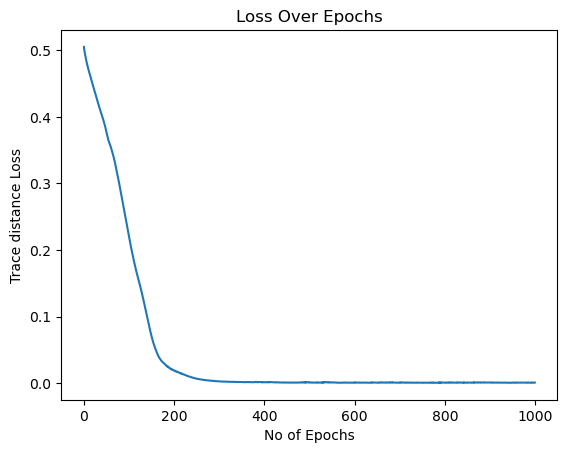

In [14]:
plt.plot(loss)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [15]:
min_loss = loss[np.argmin(loss)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.0006358800934964799


## Analyzing the trained qml.state()

In [16]:
optimal_params = parameters[np.argmin(loss)]
psi = circuit(optimal_params)

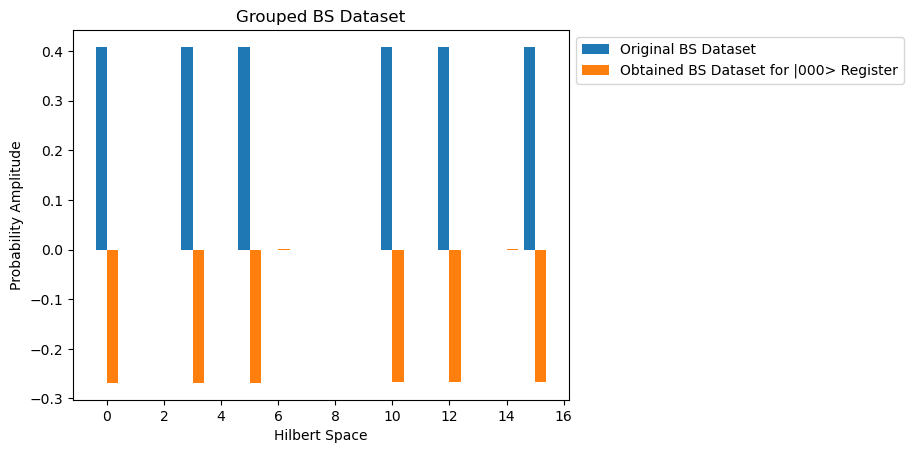

In [17]:
image1 = qnp.round(psi[::8],5)
image1 /= qnp.linalg.norm(image1)

w, x = 0.4, np.arange(len(image1))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image1, w, label='Obtained BS Dataset for |000> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

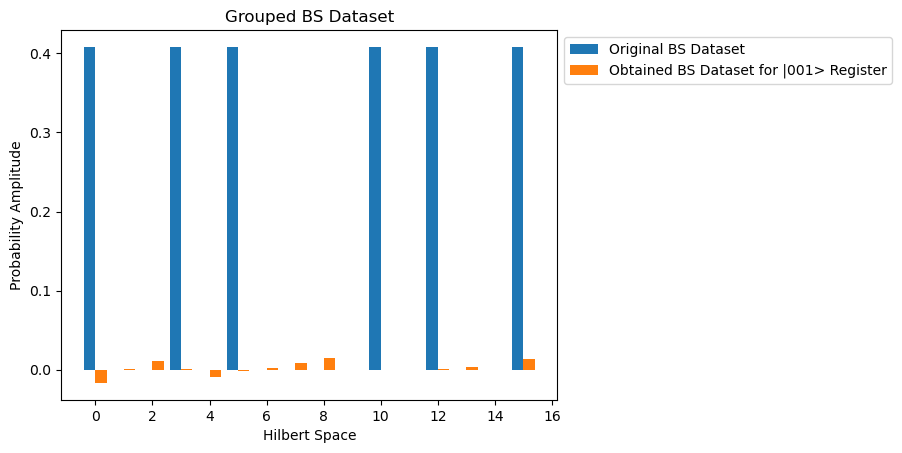

In [18]:
image2 = qnp.round(psi[1::8],5)
image2 /= qnp.linalg.norm(image2)

w, x = 0.4, np.arange(len(image2))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

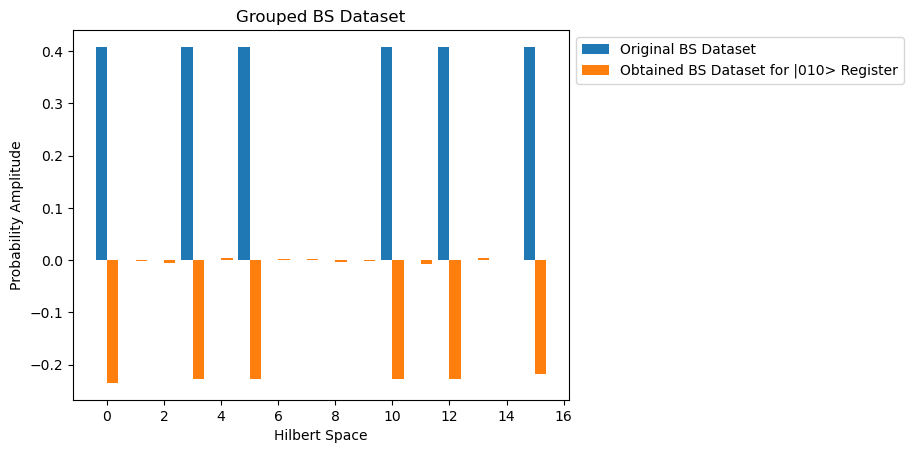

In [19]:
image3 = qnp.round(psi[2::8],5)
image3 /= qnp.linalg.norm(image3)

w, x = 0.4, np.arange(len(image3))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image3, w, label='Obtained BS Dataset for |010> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

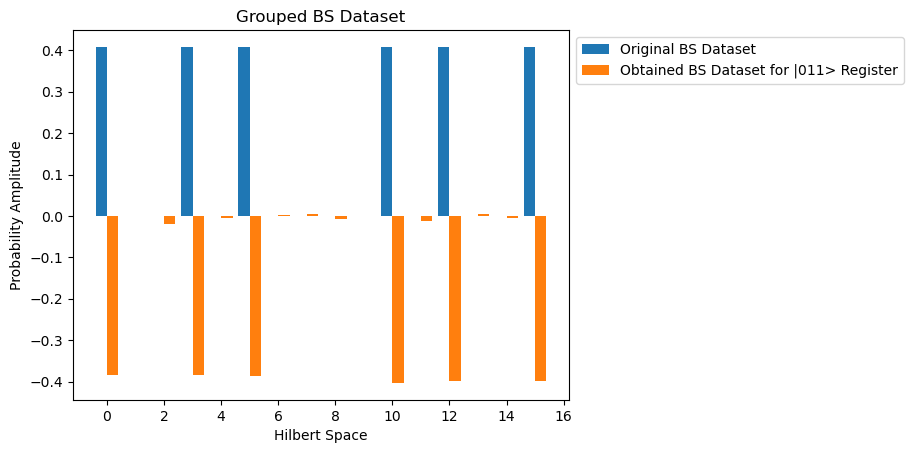

In [20]:
image4 = qnp.round(psi[3::8],5)
image4 /= qnp.linalg.norm(image4)

w, x = 0.4, np.arange(len(image4))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image4, w, label='Obtained BS Dataset for |011> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

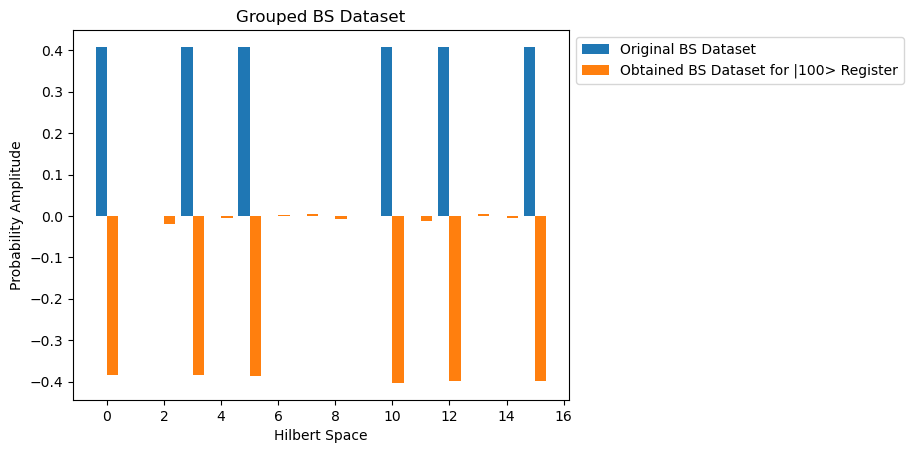

In [21]:
image5 = qnp.round(psi[4::8],5)
image5 /= qnp.linalg.norm(image5)

w, x = 0.4, np.arange(len(image4))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image4, w, label='Obtained BS Dataset for |100> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

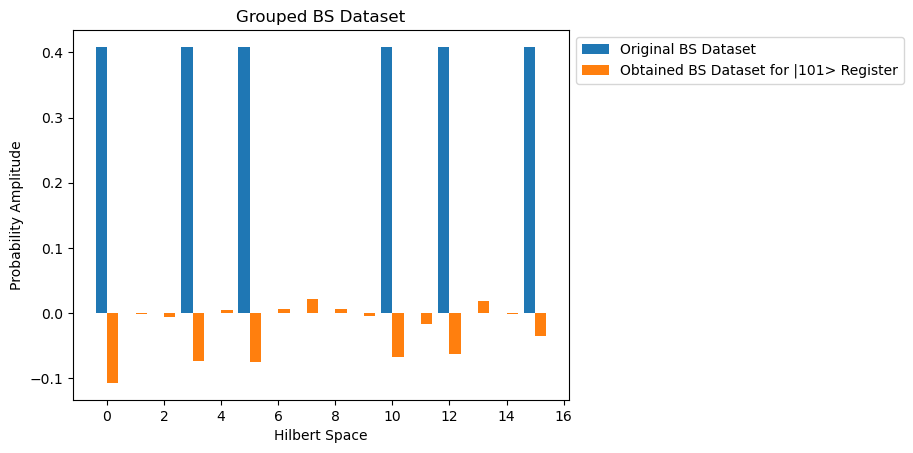

In [22]:
image6 = qnp.round(psi[5::8],5)
image6 /= qnp.linalg.norm(image6)

w, x = 0.4, np.arange(len(image6))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image6, w, label='Obtained BS Dataset for |101> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

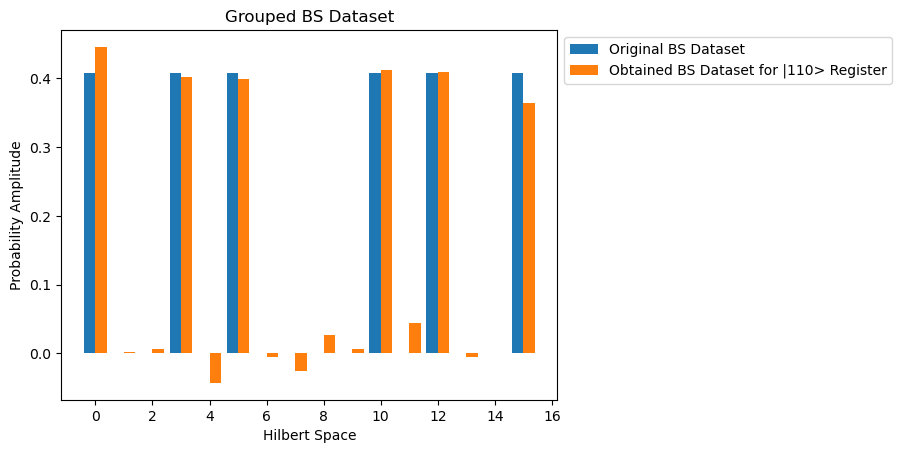

In [23]:
image7 = qnp.round(psi[6::8],5)
image7 /= qnp.linalg.norm(image7)

w, x = 0.4, np.arange(len(image7))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image7, w, label='Obtained BS Dataset for |110> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

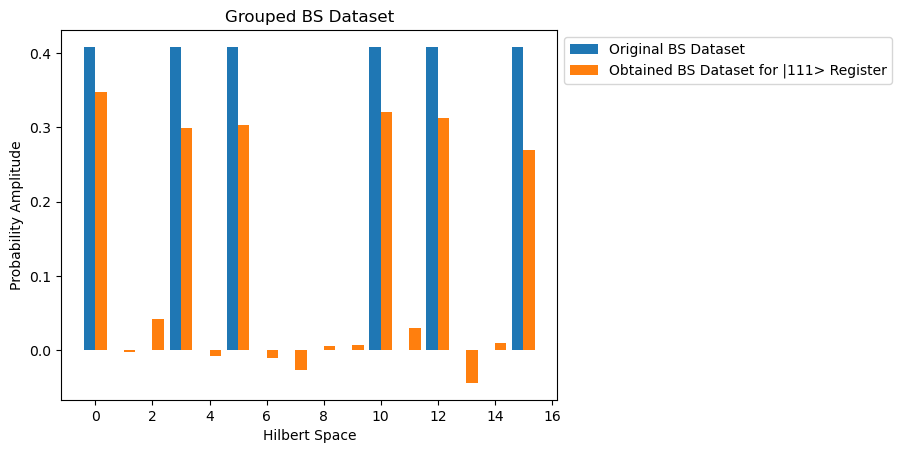

In [24]:
image8 = qnp.round(psi[7::8],5)
image8 /= qnp.linalg.norm(image8)

w, x = 0.4, np.arange(len(image8))

plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x + w/2, image8, w, label='Obtained BS Dataset for |111> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()